In [269]:
import numpy as np
import pandas as pd
import plotly.express as px

In [271]:
df = pd.read_csv('Coffe_sales.csv')

df.sample(5)

,hour_of_day,cash_type,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,Date,Time
654,12,card,37.72,Latte,Afternoon,Sun,Jun,7,6,2024-06-09,12:13:08.067000
2789,14,card,30.86,Americano with Milk,Afternoon,Thu,Jan,4,1,2025-01-30,14:41:42.277000
824,19,card,37.72,Latte,Night,Wed,Jul,3,7,2024-07-03,19:06:09.136000
1925,14,card,25.96,Cortado,Afternoon,Sun,Oct,7,10,2024-10-20,14:29:43.545000
704,11,card,37.72,Hot Chocolate,Morning,Sun,Jun,7,6,2024-06-16,11:00:38.191000


In [273]:
df['Date']=pd.to_datetime(df['Date'])


In [275]:
#5 random rows from df
df.sample(5)

,hour_of_day,cash_type,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,Date,Time
857,22,card,32.82,Latte,Night,Mon,Jul,1,7,2024-07-08,22:14:46.180000
1340,9,card,32.82,Cocoa,Morning,Tue,Sep,2,9,2024-09-03,09:13:33.655000
55,12,card,24.00,Espresso,Afternoon,Sat,Mar,6,3,2024-03-09,12:05:15.559000
576,18,card,37.72,Latte,Night,Fri,May,5,5,2024-05-31,18:23:44.636000
1354,11,card,27.92,Americano with Milk,Morning,Wed,Sep,3,9,2024-09-04,11:55:34.487000


In [277]:
#prints the whole file
#print(df.to_string())

In [279]:
#hourly and weekly heatmap of revenue
df = df.rename(columns={
    "hour_of_day": "hour",
    "Month_name": "month",
    "money": "revenue"})

#groupby: Monday at 9AM: 5 + 7 + 10 = 22 ; Monday at 10AM: 11 + 3 + 10 = 24 (similar to sql group by)
#.sum(): sums up all the buckets for Monday 9AM and Monday 10AM ect. 
grouped = df.groupby(["Weekday", "hour"])["revenue"].sum().reset_index()

print(grouped.to_string())

    Weekday  hour  revenue
0       Fri     6    87.68
1       Fri     7   575.08
2       Fri     8  1480.78
3       Fri     9  1493.50
4       Fri    10  1333.84
5       Fri    11   868.48
6       Fri    12  1193.76
7       Fri    13  1116.36
8       Fri    14  1055.62
9       Fri    15  1055.12
10      Fri    16  1084.04
11      Fri    17  1338.26
12      Fri    18  1004.68
13      Fri    19   898.40
14      Fri    20   526.10
15      Fri    21   553.04
16      Fri    22  1137.92
17      Mon     6    61.72
18      Mon     7   694.12
19      Mon     8  1241.24
20      Mon     9  1184.44
21      Mon    10  1650.78
22      Mon    11  1155.04
23      Mon    12   734.76
24      Mon    13   856.24
25      Mon    14  1389.22
26      Mon    15  1143.78
27      Mon    16  1540.10
28      Mon    17  1163.88
29      Mon    18  1096.28
30      Mon    19  1470.06
31      Mon    20   697.54
32      Mon    21   864.10
33      Mon    22   419.80
34      Sat     7    66.62
35      Sat     8   683.80
3

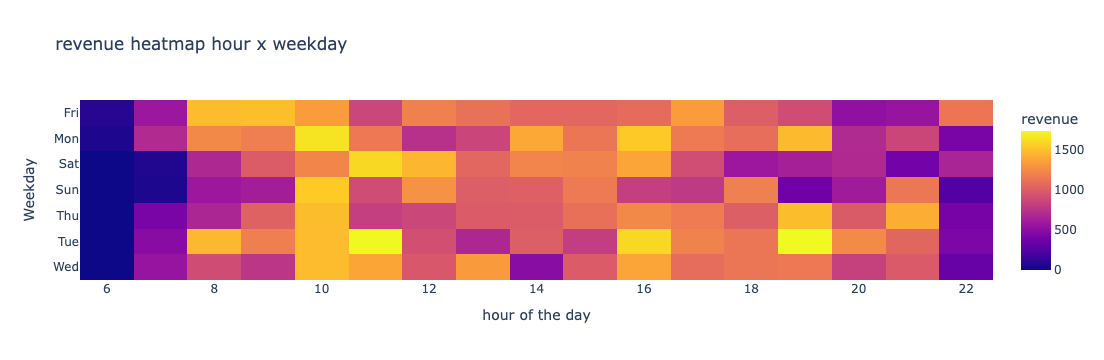

In [281]:
#heatmap process

#heat: weekday x hour with the cells being revenue 
#.fillna() still fills in the cells with color even if there is a NaN or 0 value
heat = grouped.pivot(index = "Weekday", columns = "hour", values = "revenue").fillna(0)

#the fig needs 3 items, heat stated above, labels for the X and Y and color for revenue (default) and lastly title
fig = px.imshow(
    heat, 
    labels = dict(x="hour of the day", y= "Weekday", color="revenue"),
    title = "revenue heatmap hour x weekday"
)

#prints the figure
fig.show()

In [283]:
#Calender Heatmap by Date: what hour is busiest on which weekday (date vs revenue)

import plotly.express as px

# adds all the revenue that has the same date into one row
daily = df.groupby("Date")["revenue"].sum().reset_index()


#adds new columns such as year week and weekday
daily["Date"] = pd.to_datetime(daily["Date"])
daily["year"] = daily["Date"].dt.year
#.isocalendar() is part of the datetime.datetime object returns iso year, week number, and weekday
#.day_name() is with pandas and contains datetime objects including day_name()
daily["week"] = daily["Date"].dt.isocalendar().week
daily["weekday"] = daily["Date"].dt.day_name().str[:3]
#print(daily.to_string())

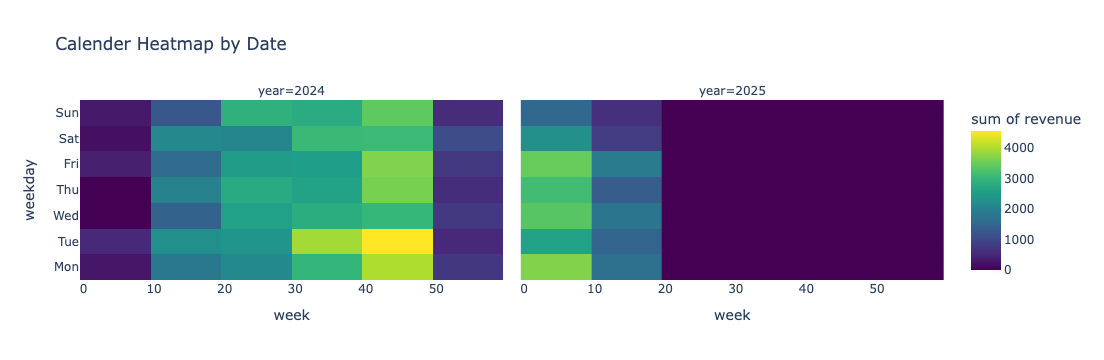

In [285]:
#creating px.density_heatmap

daily["week"] = daily["week"].astype(int) #ISO week changes value to ints 1-52
daily["weekday"] = daily["weekday"].astype(str) #changes values to string 



fig_daily = px.density_heatmap(
    daily,
    x = "week", 
    y= "weekday",
    z= "revenue",
    facet_col= "year",
    color_continuous_scale= "Viridis",
    title= "Calender Heatmap by Date")

fig_daily.update_yaxes(
    categoryorder = "array",
    categoryarray = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
)

fig_daily.show()

In [286]:
import numpy as np
import plotly.graph_objects as go


df_sankey = df[["Time_of_Day", "coffee_name", "cash_type"]].dropna().copy()

top_N = 10
top_products = df_sankey["coffee_name"].value_counts().head(top_N).index
df_sankey["coffee_name"] = np.where(
    df_sankey["coffee_name"].isin(top_products),
    df_sankey["coffee_name"],
    "Other"
)

# time of day > coffee_name
tp = df_sankey.groupby(["Time_of_Day", "coffee_name"]).size().reset_index()
tp = tp.rename(columns={0: "value"})   # <<< assign back

# coffee_name > cash_type
pc = df_sankey.groupby(["coffee_name", "cash_type"]).size().reset_index()
pc = pc.rename(columns={0: "value"})   # <<< assign back

print(tp.head())
print(pc.head())



  Time_of_Day          coffee_name  value
0   Afternoon            Americano    233
1   Afternoon  Americano with Milk    239
2   Afternoon           Cappuccino    164
3   Afternoon                Cocoa     75
4   Afternoon              Cortado     88
           coffee_name cash_type  value
0            Americano      card    564
1  Americano with Milk      card    809
2           Cappuccino      card    486
3                Cocoa      card    239
4              Cortado      card    287


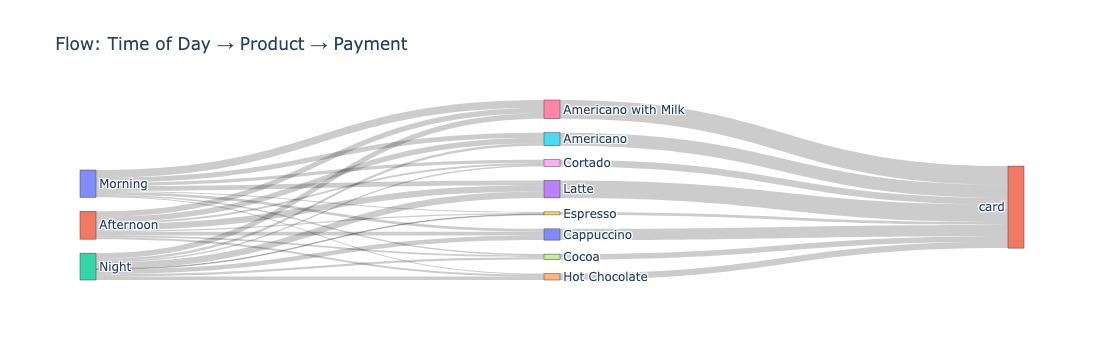

In [288]:
# 4) nodes
times = df_sankey["Time_of_Day"].astype(str).unique().tolist()
products = df_sankey["coffee_name"].astype(str).unique().tolist()
payment = df_sankey["cash_type"].astype(str).unique().tolist()

nodes = times + products + payment
node_index = {name: i for i, name in enumerate(nodes)}

# 5) links
sources, targets, values = [], [], []

for _, r in tp.iterrows():
    sources.append(node_index[r["Time_of_Day"]])
    targets.append(node_index[r["coffee_name"]])
    values.append(float(r["value"]))

for _, r in pc.iterrows():
    sources.append(node_index[r["coffee_name"]])
    targets.append(node_index[r["cash_type"]])
    values.append(float(r["value"]))

# 6) plot
fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(label=nodes, pad=14, thickness=16),
    link=dict(source=sources, target=targets, value=values)
)])
fig.update_layout(title_text="Flow: Time of Day → Product → Payment", font_size=12) 
fig.show()
